In [1]:
# 09_opponent_adjustments.ipynb
# 📊 Opponent-Adjusted Efficiency Metrics

# 🛠 Requirements: pandas, matplotlib, seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

DATA_DIR = "./data"

plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [15,8]

In [2]:
# 📂 Load 2023 advanced game stats and game metadata

game_stats = pd.read_csv(os.path.join(DATA_DIR, "advanced_game_stats", "2023.csv"))
games = pd.read_csv(os.path.join(DATA_DIR, "games.csv"))

# Filter only FBS games
games = games.query("season == 2023 and home_classification == 'fbs' and away_classification == 'fbs'")
game_stats = games[["id"]].merge(game_stats, how="inner", left_on="id", right_on="gameId")

/tmp/ipykernel_24596/1274009274.py:4: DtypeWarning: Columns (5,7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  games = pd.read_csv(os.path.join(DATA_DIR, "games.csv"))


In [3]:
# 🔗 Join each row with the opponent's per-game average

# Step 1: Compute each team's per-game average strength
df_agg = game_stats.groupby("team").agg({
    "offense_ppa": "mean",
    "defense_ppa": "mean"
}).rename(columns={"offense_ppa": "avg_off_ppa", "defense_ppa": "avg_def_ppa"}).reset_index()

# Step 2: Merge with game logs using the "opponent" column
adjusted = game_stats.merge(df_agg, how="inner", left_on="opponent", right_on="team", suffixes=("", "_opponent"))

In [5]:
# 🧠 Create an adjusted metric: difference between raw and opponent average allowed
adjusted["adj_offense_ppa"] = adjusted["offense_ppa"] - adjusted["avg_def_ppa"]
adjusted["adj_defense_ppa"] = adjusted["defense_ppa"] - adjusted["avg_off_ppa"]

adjusted[["team", "opponent", "offense_ppa", "defense_ppa", "avg_off_ppa", "avg_def_ppa", "adj_offense_ppa", "adj_defense_ppa"]].head(10)

,team,opponent,offense_ppa,defense_ppa,avg_off_ppa,avg_def_ppa,adj_offense_ppa,adj_defense_ppa
0,Jacksonville State,UTEP,0.030189,0.060931,0.124526,0.251920,-0.221732,-0.063595
1,UTEP,Jacksonville State,0.060931,0.030189,0.090807,0.050086,0.010845,-0.060618
2,Florida International,Louisiana Tech,0.034831,0.103298,0.106110,0.236741,-0.201910,-0.002811
3,Louisiana Tech,Florida International,0.103298,0.034831,0.076042,0.196904,-0.093605,-0.041210
4,Hawai'i,Vanderbilt,0.240675,0.109741,0.047948,0.330402,-0.089727,0.061793
5,Vanderbilt,Hawai'i,0.109741,0.240675,0.120856,0.252596,-0.142855,0.119819
6,Minnesota,Nebraska,-0.038357,-0.082255,0.105584,0.077991,-0.116348,-0.187839
7,Nebraska,Minnesota,-0.082255,-0.038357,0.075479,0.199541,-0.281796,-0.113836
8,Alabama,Middle Tennessee,0.490459,0.089936,0.121519,0.169814,0.320645,-0.031584
9,Middle Tennessee,Alabama,0.089936,0.490459,0.248239,0.128592,-0.038657,0.242220


In [6]:
# 📊 Aggregate adjusted PPA per team

team_adj = adjusted.groupby("team")[["adj_offense_ppa", "adj_defense_ppa"]].mean().reset_index()
team_raw = game_stats.groupby("team")[["offense_ppa", "defense_ppa"]].mean().reset_index()

team_merged = team_raw.merge(team_adj, on="team")
team_merged['raw_diff'] = team_merged['offense_ppa'] - team_merged['defense_ppa']
team_merged['adj_diff'] = team_merged['adj_offense_ppa'] - team_merged['adj_defense_ppa']
team_merged = team_merged.rename(columns={
    "offense_ppa": "Raw Offense EPA",
    "adj_offense_ppa": "Adj Offense EPA",
    "defense_ppa": "Raw Offense EPA",
    "adj_defense_ppa": "Adj Offense EPA",
    "raw_diff": "Raw EPA Diff",
    "adj_diff": "Adj EPA Diff"
}).sort_values("Adj EPA Diff", ascending=False)

team_merged.head(10)

,team,Raw Offense EPA,Raw Offense EPA,Adj Offense EPA,Adj Offense EPA,Raw EPA Diff,Adj EPA Diff
83,Oregon,0.447598,0.069913,0.237781,-0.128850,0.377685,0.366631
33,Georgia,0.392502,0.089276,0.210600,-0.110222,0.303226,0.320823
78,Ohio State,0.280540,0.002347,0.155504,-0.159983,0.278193,0.315488
76,Notre Dame,0.317758,0.009127,0.161770,-0.140759,0.308631,0.302529
60,Michigan,0.286298,-0.008863,0.153433,-0.142375,0.295160,0.295808
79,Oklahoma,0.326189,0.070408,0.134525,-0.140401,0.255781,0.274925
85,Penn State,0.235761,-0.028905,0.092186,-0.171045,0.264666,0.263231
49,LSU,0.474962,0.264089,0.317134,0.087820,0.210873,0.229313
65,Missouri,0.272587,0.125594,0.107290,-0.107695,0.146993,0.214984
2,Alabama,0.248239,0.128592,0.114855,-0.095355,0.119647,0.210209


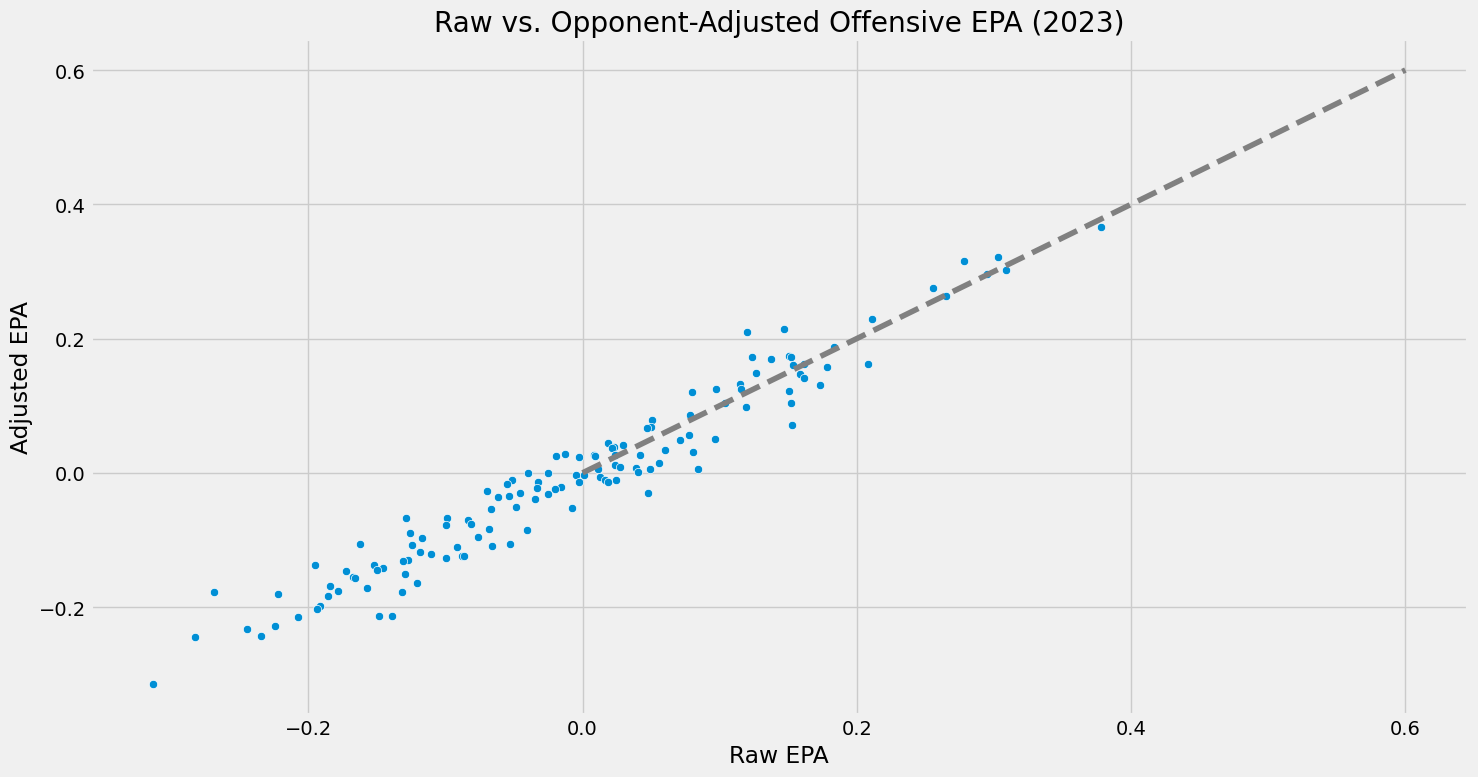

In [7]:
# 📈 Plot raw vs. adjusted EPA

sns.scatterplot(data=team_merged, x="Raw EPA Diff", y="Adj EPA Diff")
plt.title("Raw vs. Opponent-Adjusted Offensive EPA (2023)")
plt.plot([0, 0.6], [0, 0.6], linestyle="--", color="gray")  # Diagonal line
plt.xlabel("Raw EPA")
plt.ylabel("Adjusted EPA")
plt.tight_layout()
plt.show()

In [47]:
# ✅ Summary

# In this notebook, you:
# - Calculated each opponent’s average defensive EPA allowed
# - Adjusted each team’s offensive EPA for opponent difficulty
# - Aggregated adjusted metrics to create a fairer ranking
# - Compared raw vs. adjusted efficiency

# 🧪 Try This:
# - Do the same for success rate or explosiveness
# - Adjust defensive stats by average opposing offense
# - Create an “opponent-adjusted net rating” = adj_off_epa - adj_def_epa